#### OBJETIVO: Analisis de las predicciones obtenidas de los mapas diarios

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
print("libreria ok")

libreria ok


In [2]:
estacion = "SP"
#Ubicacion de todos los archivos, generados antes y guardados
base_path = Path("D:/Josefina/Proyectos/Tesis")
# Corresponde a las predicciones realizadas con los modelos con/sin AOD
# Con AOD
file_AOD = base_path / estacion / "resultados/merge_Prediccion_Real" / \
           f"{estacion}_merge_01-XGB-CV-M1-200525-{estacion}.csv"

data = pd.read_csv(file_AOD, encoding="latin1")
data["date"] = pd.to_datetime(data["date"])

# Sin AOD
file_sAOD = base_path / estacion / "resultados/merge_Prediccion_Real" / \
            f"{estacion}_merge_02-XGB-CV-1-210525-sAOD-{estacion}.csv" #### Corrobhorar el modelo en cada sitio

data_sAOD = pd.read_csv(file_sAOD, encoding="latin1")
data_sAOD["date"] = pd.to_datetime(data_sAOD["date"])

print(data.columns)
print(data_sAOD.columns)



Index(['Unnamed: 0', 'ID', 'date', 'estacion.x', 'Direccion', 'Zona', 'lat',
       'long', 'Considerado', 'finalmente.usado', 'valor_raster', 'X',
       'estacion.y', 'mean', 'min', 'max', 'sd'],
      dtype='object')
Index(['Unnamed: 0', 'ID', 'date', 'estacion.x', 'Direccion', 'Zona', 'lat',
       'long', 'Considerado', 'finalmente.usado', 'valor_raster', 'X',
       'estacion.y', 'mean', 'min', 'max', 'sd'],
      dtype='object')


C:\Users\Josefina Urquiza\AppData\Local\Temp\ipykernel_1164\2187507876.py:16: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_sAOD = pd.read_csv(file_sAOD, encoding="latin1")


In [3]:
#Hacemos solo el analisis para el 2024
#Probar igual con todo el dataset segun el interes
data = data[data["date"].dt.year == 2024]
data_sAOD = data_sAOD[data_sAOD["date"].dt.year == 2024]

#Corrorobamos que años considera
print(data["date"].dt.year.unique())
print(data_sAOD["date"].dt.year.unique())


[2024]
[2024]


In [4]:
#Se agrupan los datos por dia para ambos dataset
#Con AOD
data_AOD_diario = (
    data
    .groupby("date", as_index=False)
    .agg(
        mean_pm25_AOD=("mean", "mean"),
        mean_valor_raster_AOD=("valor_raster", "mean")
    )
)
#Sin AOD
data_sAOD_diario = (
    data_sAOD
    .groupby("date", as_index=False)
    .agg(
        mean_pm25_sAOD=("mean", "mean"),
        mean_valor_raster_sAOD=("valor_raster", "mean")
    )
)


In [5]:
#Se unen ambos dataset segun la fecha
# Revisamos queno haya info con NA
data_merged = pd.merge(
    data_sAOD_diario,
    data_AOD_diario,
    on="date",
    how="left"
)

print(data_merged["date"].dt.year.unique())
data_merged


[2024]


,date,mean_pm25_sAOD,mean_valor_raster_sAOD,mean_pm25_AOD,mean_valor_raster_AOD
0,2024-01-01,13.645191,11.120554,NaN,NaN
1,2024-01-02,12.349567,16.650700,12.349567,16.097493
2,2024-01-03,8.725279,14.685934,NaN,NaN
3,2024-01-04,3.781885,12.143718,NaN,NaN
4,2024-01-05,7.044488,12.003663,7.044488,7.771470
...,...,...,...,...,...
361,2024-12-27,6.514719,8.067260,NaN,NaN
362,2024-12-28,9.807193,14.001479,NaN,NaN
363,2024-12-29,8.241005,10.736312,8.241005,8.682558
364,2024-12-30,7.993437,11.012643,NaN,NaN


In [6]:
#Nos quedamos solo con algunas variables
data_long = data_merged.melt(
    id_vars="date",
    value_vars=[
        "mean_pm25_sAOD",
        "mean_valor_raster_sAOD",
        "mean_valor_raster_AOD"
    ],
    var_name="variable",
    value_name="valor"
)
data_long

,date,variable,valor
0,2024-01-01,mean_pm25_sAOD,13.645191
1,2024-01-02,mean_pm25_sAOD,12.349567
2,2024-01-03,mean_pm25_sAOD,8.725279
3,2024-01-04,mean_pm25_sAOD,3.781885
4,2024-01-05,mean_pm25_sAOD,7.044488
...,...,...,...
1093,2024-12-27,mean_valor_raster_AOD,NaN
1094,2024-12-28,mean_valor_raster_AOD,NaN
1095,2024-12-29,mean_valor_raster_AOD,8.682558
1096,2024-12-30,mean_valor_raster_AOD,NaN


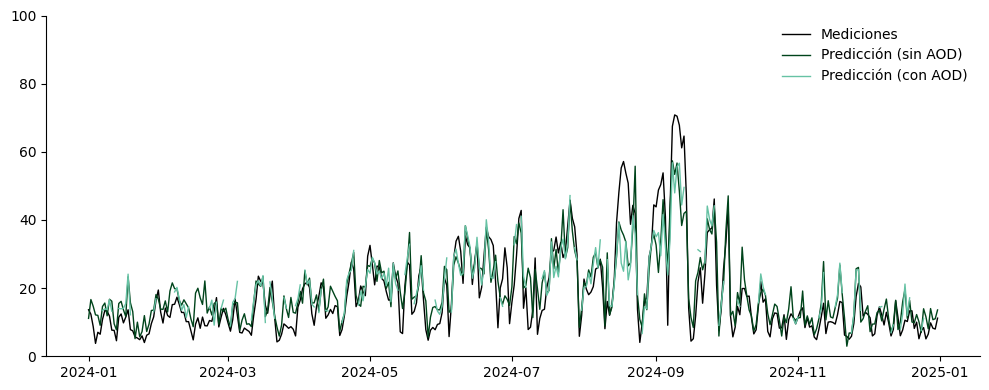

In [7]:
#Hacemos plot que tengan las mediciones vs as predicciones con/sin AOD
plt.figure(figsize=(10, 4))

palette = {
    "mean_pm25_sAOD": ("Mediciones", "black"),
    "mean_valor_raster_sAOD": ("Predicción (sin AOD)", "#00441b"),
    "mean_valor_raster_AOD": ("Predicción (con AOD)", "#66c2a4"),
}

for var, (label, color) in palette.items():
    subset = data_long[data_long["variable"] == var]
    plt.plot(
        subset["date"],
        subset["valor"],
        label=label,
        color=color,
        linewidth=1
    )

plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 20))

plt.xlabel("")
plt.ylabel("")
plt.legend(frameon=False)

sns.despine()
plt.tight_layout()
plt.show()



In [8]:
#Algunas metricas simples
data_AOD_diario["mean_pm25_AOD"].mean()
data_AOD_diario["mean_pm25_AOD"].std()

data_AOD_diario["mean_valor_raster_AOD"].mean()
data_AOD_diario["mean_valor_raster_AOD"].std()


data_sAOD_diario["mean_pm25_sAOD"].mean()
data_sAOD_diario["mean_pm25_sAOD"].std()

data_sAOD_diario["mean_valor_raster_sAOD"].mean()
data_sAOD_diario["mean_valor_raster_sAOD"].std()


print("-----------------------mean_pm25_AOD-----------------------------")
print((data_AOD_diario["mean_pm25_AOD"].describe()))


print("-----------------------mean_valor_raster_AOD-----------------------------")
print((data_AOD_diario["mean_valor_raster_AOD"].describe()))



-----------------------mean_pm25_AOD-----------------------------
count    232.000000
mean      22.031603
std       13.460824
min        5.872033
25%       12.170150
50%       17.878689
75%       28.136233
max       70.824938
Name: mean_pm25_AOD, dtype: float64
-----------------------mean_valor_raster_AOD-----------------------------
count    232.000000
mean      22.189758
std        9.936316
min        6.686252
25%       14.509003
50%       20.938942
75%       27.339254
max       56.796404
Name: mean_valor_raster_AOD, dtype: float64
